In [ ]:
import numpy as np
import time
import math
import modules as md
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [1]:
#------------------------------------------------------------------------------------------
#Units and conversions:
#------------------------------------------------------------------------------------------
#code units: Rsun, Msun, G=1, ...
c_SI       = 299792458.0        #m/s
M_sun_SI   = 1.989*(10.**30.)   #kg
R_sun_SI   = 695800000.         #m
R_bull_SI = 1000 #m 
AU_SI      = 149597871000.      #m 
G_new_SI   = 6.67*(10.**(-11.)) #m**3 kg**(-1) s**(-2)
AU_U       = AU_SI/R_sun_SI                             #from dist AU to code units (U)
kmsec_U    = 1000./np.sqrt(G_new_SI*M_sun_SI/R_bull_SI)  #from vel km/sec to code units (U)
time_U     = 1/np.sqrt(G_new_SI*M_sun_SI/R_bull_SI**3) #from CU to second np.sqrt((R_bull_SI)/(G_new_SI*M_sun_SI)) #from code units(U) to time sec
#Rsch_1Msun_unitRsun = ((2.*G_new_SI*(1.*M_sun_SI))/(c_SI**2.))/R_sun_SI
c_CU = c_SI/1000*kmsec_U

$$ N_2 r_{o}^5 F_{2m}^{Sch} = \frac{i}{360} r^6_{o} \omega $$

$$N_2 r_{o}^5 F^{Kerr}_{2m} = - \frac{i}{360} \frac{(ma - r_o r_{+}\omega)}{r_{+} - r_{-}} = - \frac{i}{360} \frac{m}{r_{+} - r_{-}}a + \frac{i}{360} \frac{r_o r_{+}}{r_{+} - r_{-}}\omega $$

$$N_2 r_{o}^5 F^{Kerr}_{2m}  = + \frac{i}{180} \frac{r_o^5}{r_{+} - r_{-}} a + \frac{i}{360} \frac{r_o^6 r_{+}}{r_{+} - r_{-}}\omega = i \eta_{a} a + i \eta_{E} \omega$$

$$ \eta_E = \frac{r^6_{o}}{360}  $$

$$F_{2m}^{kerr} = - \frac{i}{120} \frac{ma - 2 M r_{+} \omega}{r_+ - r_-} = - \frac{i}{120} \sum_{m} \frac{ma - 2 M r_{+} \omega}{r_+ - r_-}$$

## Newtonian 

In [2]:
#Acceleration

def acc(r,m): #r position, m mass
    a = np.zeros((len(r),3)) #Create acceleration vector
    for i in range(len(r)): #Range is size of timesteps or position steps
        for j in range(len(r)): #For each particle
            if (i != j):
                rrel = r[i]-r[j]
                rn = (rrel**2).sum()**(1./2) 
                a[i] += -(rrel)*m[j]/(rn**3.0) #Acceleration at each time step 
    return a # return acceleration


def Jerk(r,v,m): #position, velocity, mass
    Je = np.zeros((len(r),3)) #Define the Jerk
    for i in range(len(r)):
        for j in range(len(r)):
            if (i != j):
                rrel = r[i]-r[j]
                vrel = v[i]-v[j]
                rn = (rrel**2).sum()**(1./2) # dot product
                vn = (vrel**2).sum()**(1./2)
                rvd = ((rrel)*(vrel)).sum()
                Je[i] += - m[j]*((vrel)/rn**3.0 - 3.*(rvd*rrel/(rn**5.0))) 
    return Je;



# Dissipative effects

In [76]:
def accdiss(r,v,m,ne): #r position, m mass, s spin, m mass of the star and the value of ne
    a = np.zeros((len(r),3)) #Create acceleration vector
    a1 = np.zeros((len(r),3)) #Create acceleration vector
    a2 = np.zeros((len(r),3)) #Create acceleration vector
    #a3 = np.zeros((len(r),3)) #Create acceleration vector
    for i in range(len(r)): #Range is size of timesteps or position steps
        for j in range(len(r)): #For each particle
            if (i != j):
                rrel = r[i]-r[j]
                vrel = v[i]-v[j]
                rn = ((rrel**2).sum())**(1./2) #dot product
                runi = rrel/rn
                a1[i] += -(9.)*ne[i]*((m[j]**2)/m[i])*(vrel)/(rn**8.0) #Acceleration at each time step    
                a2[i] += -(18.)*ne[i]*((m[j]**2)/m[i])*(runi*((runi*vrel).sum()))/(rn**8.0)
                #a3[i] += -(9.)*ne[i]*((m[j]**2)/m[i])*(vrel)/(rn**8.0)
                a[i] = a1[i] + a2[i] #+ a3[i] 
                #This is the term that becomes zero in a circular orbit
                #a[i,:] += -(18.)*ne[i]*((m[j]**2)/m[i])*(runi)*((runi*vrel).sum())/(rn**8.0) #Acceleration at each time step 
    return a # return acceleration


def Jerkdiss(r,v,a,m, ne): #r position, v velocity, m mass, m mass of the star, ne
    Je = np.zeros((len(r),3)) #Define the Jerk
    Je1 = np.zeros((len(r),3)) #Define the Jerk
    Je2 = np.zeros((len(r),3)) #Define the Jerk

    for i in range(len(r)):
        for j in range(len(r)):
            if (i != j):
                rrel = (r[i]-r[j])
                vrel = (v[i]-v[j])
                arel = (a[i]-a[j])
                rn = ((rrel**2).sum())**(1./2) # dot product
                vn = ((vrel**2).sum())**(1./2)
                Je1[i] += - (9.0)*ne[i]*((m[j]**2)/m[i])*( arel/rn**8.0 - 8.*((vrel*rrel).sum())*(vrel)/(rn**10.0) )                 
                Je2[i] += - (18.0)*ne[i]*((m[j]**2)/m[i])*((arel*((rrel*vrel).sum()) + rrel*((rrel*arel).sum() + vn**2))/(rn**10.0) - (10*rrel*(((rrel*vrel).sum())**2))/(rn**12.0))
                Je[i] = Je1[i] + Je2[i]
    return Je;


####v2
def HermiteUpdatedissdt(dt, r, v, m, ns): # m mass of the star
    
    aN = acc(r, m) 
    aD = accdiss(r, v, m, ns)
    a = aN + aD           # current acceleration
    aNdot = Jerk(r,v,m)
    aDdot = Jerkdiss(r, v, a, m, ns)
    adot = aNdot + aDdot # current jerks
    rp = r + dt*v + dt**2/2 * a + dt**3/6* adot   # predict
    vp = v + dt*a + dt**2/2 * adot

    aNp = acc(rp, m)
    aDp = accdiss(rp, vp, m, ns)
    ap = aNp + aDp         # predicted acceleration

    aNdotp = Jerk(rp, vp, m)
    aDdotp = Jerkdiss(rp, vp, ap, m, ns)
    adotp = aNdotp + aDdotp  # predicted jerks 
    
    dtp = dt
    
    vc = v + dt/2*(a+ap) - dt**2/12*(adotp-adot)  # correct
    rc = r + dt/2*(v + vp) - dt**2/12 * (ap-a)
    ac = a + dt/2*(adotp+adot)
    aNc = aN + dt/2*(aNdotp + aNdot)
 
    return rc,vc,ac,aNc,dtp

def Hermite4thdissdt(pri,sec, bina, nsteps, Dt):
    
    N=2
    m = np.ones(N)#/N #Remove the N if not necessary
    m[0]=pri.mass
    m[1]=sec.mass
    
    r_res = np.zeros((2,3,nsteps)) # 2 because of two bodies
    v_res = np.zeros((2,3,nsteps))

    aN_res = np.zeros((2,3,nsteps)) # 2 because of two bodies
    adotN_res = np.zeros((2,3,nsteps))

    a_res = np.zeros((2,3,nsteps)) # 2 because of two bodies
    adot_res = np.zeros((2,3,nsteps))

    
    time = np.zeros(nsteps)
    r_res[:,:,0] = bina.r.copy()
    v_res[:,:,0] = bina.v.copy()
    etav = np.array([pri.eta, sec.eta])
    
    dtp = np.zeros(nsteps)
    dtp[0] = Dt
    
    for i in range(1,nsteps):
        (r_res[:,:,i],v_res[:,:,i],a_res[:,:,i],aN_res[:,:,i],dtp[i]) = HermiteUpdatedissdt(Dt, r_res[:,:,i-1], v_res[:,:,i-1], m, etav)
        time[i] = time[i-1] + Dt#+ dtp[i-1] #+ Dt #
        if time[i] >= timelimit:
            break
            
    r_res = r_res[:,:,:i]
    v_res = v_res[:,:,:i]
    a_res = a_res[:,:,:i]
    #adot_res = adot_res[:,:,:i]
    aN_res = aN_res[:,:,:i]
    #adotN_res = adotN_res[:,:,:i]
    dtp = dtp[:i]
    time = time[:i]
        
    return r_res, v_res, a_res, aN_res, dtp, time

## Circular Orbit 

In [77]:
bh = md.Particle("BH",10,0,0) #stellar type, mass, radius, spin. At the momento for black holes choose r=0 and will set the Schwarzchild radius

bhbhco = md.Binary(bh,bh, 5*bh.radi,0)

In [78]:
accu = 0.001 # Set accuracy parameter 0.0000000001  works good, try add another 0
tl = 1*bhbhco.periodct #Time of the simulation in [cpde units]
timelimit = tl #
dt = 0.1 # 0.0005 working better, 
Nsteps = int(tl/dt)#Number of timesteps with the guessed timestep 


In [7]:
rc,vc,ac,aNc,dtp,time = Hermite4thdissdt(bh,bh, bhbhco, Nsteps, dt)

In [9]:
print(max(dtp))
print(min(dtp[1:]))

0.1
0.1


In [60]:
#aTcoc = aTco + adotTco*dtpwtco#Acceleration corrected
#aNcoc = aNco + adotNco*dtpwtco

aratio = np.zeros_like(aNc[1].T)
for i in range(len(aNc[1].T)-1):
    aratio[i+1][0] = (ac[1].T[i+1][0])/(aNc[1].T[i+1][0])
    aratio[i+1][1] = (ac[1].T[i+1][1])/(aNc[1].T[i+1][1])
    #print(aratio[i][1])
    
#define relative position
relposT = rc[1].T - rc[0].T 
#define relative velocity
relvelT = vc[1].T - vc[0].T

normrelposT = np.zeros([len(relposT), 1]) 
normrelvelT = np.zeros([len(relvelT), 1]) 
rdotv = np.zeros([len(relvelT), 1]) 
runidotv = np.zeros([len(relvelT), 1]) 


for i in range(len(normrelposT)):
    normrelposT[i] = np.sqrt(relposT[i][0]**2 + relposT[i][1]**2 + relposT[i][2]**2)
    normrelvelT[i] = np.sqrt(relvelT[i][0]**2 + relvelT[i][1]**2 + relvelT[i][2]**2)
    rdotv[i] = np.dot(relposT[i], relvelT[i])
    runidotv[i] = np.dot(relposT[i], relvelT[i])/normrelposT[i]
    
print(len(normrelposT.T[0]))
print(min(normrelposT))
print(max(normrelposT))

25195
[147.60983881]
[147.61116613]


In [66]:
runidotv.T[0]

array([ 0.00000000e+00, -1.63780765e-14, -6.55122823e-14, ...,
       -5.24321904e-11, -5.23001427e-11, -5.22008507e-11])

In [79]:
n_exco = (normrelposT.T[0]**6)*(1./9)*(1.*bh.mass/bh.mass)*(1./(relvelT.T[0]-2*runidotv.T[0]))*(aratio.T[0] - 1) 
n_eyco = (normrelposT.T[0]**6)*(1./9)*(1.*bh.mass/bh.mass)*(1./(relvelT.T[1]-2*runidotv.T[0]))*(aratio.T[1] - 1)

/home/irvin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


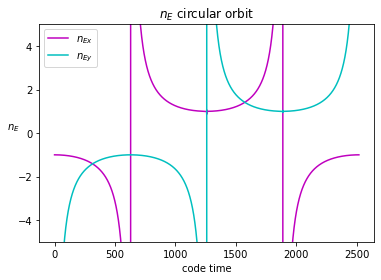

In [84]:
plt.plot(time[1:], n_exco[1:]/bh.eta, 'm-', label = r'$n_{Ex}$', alpha = 1)
plt.plot(time[1:], n_eyco[1:]/bh.eta, 'c-', label = r'$n_{Ey}$', alpha = 1)
#plt.plot(timearrayN.T[0][2:], n_ey[1:], 'b-', label = r'$n_{Ey}$', alpha = 0.5)
#plt.plot(timearrayT[1:], posydif, 'b-', label = r'$\Delta y$', alpha = 0.8)

#plt.plot(timeave, dynstave.T[1], 'b-', label = r'$star$', alpha = 0.8)
#plt.plot(time[1:], n_e.T[2], 'g-', label = r'$n_{ez}$', alpha = 0.8)
#plt.xlim(0,1000)
plt.ylim(-5,5)
#2234355.8738294537
plt.xlabel('code time')
plt.ylabel(r'$n_{E}$',rotation=0)

plt.title(r'$n_{E}$ circular orbit')
plt.legend()
#plt.savefig('ne-evolution-circular-0.001-3rt.png', bbox_inches='tight', dpi=300)#, dpi=300

plt.show()

In [28]:
max(aratio.T[0])
max(aratio.T[1])
min(aratio.T[1])

0.0

In [47]:
n_eyco[20000]

2321732.641973236

In [23]:
print(len(relvelT.T[0]))

25195


In [25]:
nt =10000

print((np.abs(aratio.T[1][nt]-1))/(1./np.abs(relvelT.T[0][nt]))*(normrelposT.T[0][nt]**6))

2172430.389425021


In [17]:
print(bh.eta)

2234355.8738294537


In [38]:
plt.plot(timewtco[1:], n_eyco, 'c-', label = r'$n_{E}$', alpha = 1)
#plt.plot(timearrayN.T[0][2:], n_ey[1:], 'b-', label = r'$n_{Ey}$', alpha = 0.5)
#plt.plot(timearrayT[1:], posydif, 'b-', label = r'$\Delta y$', alpha = 0.8)

#plt.plot(timeave, dynstave.T[1], 'b-', label = r'$star$', alpha = 0.8)
#plt.plot(time[1:], n_e.T[2], 'g-', label = r'$n_{ez}$', alpha = 0.8)
#plt.xlim(0,1000)
#plt.ylim(2000000,2334355)
plt.xlabel('code time')
plt.ylabel(r'$n_{E}$',rotation=0)

plt.title(r'$n_{E}$ circular orbit')
plt.legend()
#plt.savefig('ne-evolution-circular-0.001-3rt.png', bbox_inches='tight', dpi=300)#, dpi=300

plt.show()

NameError: name 'timewtco' is not defined

In [ ]:
print(min(n_exco[1:]))
print(max(n_exco))
print(bh.eta)


In [ ]:
np.where(n_e)

In [ ]:
print(min(n_exco[1:]))
print(max(n_exco))
print(ns.ntide)

In [ ]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(rwtco[0][0], rwtco[0][1], rwtco[0][2], 'c', linewidth=1)# Plot the BH orbit
ax.plot(rwtco[1][0], rwtco[1][1], rwtco[1][2], 'm', linewidth=1)# Plot the star orbit
ax.scatter3D(rwtco[0][0][-1], rwtco[0][1][-1], rwtco[0][2][-1], 'o', c='black') #s=100
ax.scatter3D(rwtco[1][0][-1], rwtco[1][1][-1], rwtco[1][2][-1], '0', c='orange') #s=10
ax.legend()
#ax.set_xticks([])
#ax.set_yticks([])
#ax.set_zticks([])
#ax.set_xlim3d(-1,1)
#ax.set_ylim3d(-1,1)
#ax.set_xlim3d(min(min(posbh1x), min(posbh2x)), max(max(posbh1x), max(posbh2x)))
#ax.set_ylim3d(min(min(posbh1y), min(posbh2y)), max(max(posbh1y), max(posbh2y)))
#ax.set_zlim3d(min(min(posbh1z), min(posbh2z)), max(max(posbh1z), max(posbh2z)))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')


#plt.savefig('ne-circular10rt.png',bbox_inches='tight', dpi=300)#, dpi=300

plt.show()

In [ ]:
bh3.radi

In [ ]:
#Define binary
bh3ns10rt = md.Binary(bh3, ns, 4*ns.radi, 0)

rt = 2

bh3nsco = md.Binary(bh3, ns, rt*bh3ns10rt.tidalrsec, 0) ##primary, secondary, orbital distance (Rsun), eccentricity


#bh3nsco.orbd = rt*bh3nsco.tidalrsec

print(bh3nsco.orbd)
print(bh3nsco.tideeffsec)

print(ns.radi)
print(bh3nsco.tidalrsec)


In [ ]:
accu = 0.001 # Set accuracy parameter 0.0000000001  works good, try add another 0
tl = 1*bh3nsco.periodct #Time of the simulation in [cpde units]
timelimit = tl #
dt = 0.0001 # 0.0001 working better 
Nsteps = int(tl/dt)#Number of timesteps with the guessed timestep 


#Better accuracy
#accu = 0.00000000001 # Set accuracy parameter 0.0000000001  works good, try add another 0
#tl = 0.15*bh3nsrt.periodct #Time of the simulation in [cpde units]
#timelimit = tl #
#dt = 0.0005 # 0.0001 working better 
#Nsteps = int(tl/dt)#Number of timesteps with the guessed timestep 


In [ ]:
rwtco,vwtco,aTco,adotTco,aNco,adotNco,dtpwtco,timewtco = Hermite4thtidedt(bh3,ns, bh3nsco, Nsteps, dt)

In [ ]:
print(max(dtpwtco))
print(min(dtpwtco[1:]))

In [ ]:
aTcoc = aTco + adotTco*dtpwtco#Acceleration corrected
aNcoc = aNco + adotNco*dtpwtco

aratioco = np.zeros_like(aNco[1].T)
for i in range(len(aNco[1].T)-1):
    aratioco[i+1][0] = (aTcoc[1].T[i+1][0])/(aNcoc[1].T[i+1][0])
    aratioco[i+1][1] = (aTcoc[1].T[i+1][1])/(aNcoc[1].T[i+1][1])
    #print(aratio[i][1])
    
#define relative position
relposTco = rwtco[1].T - rwtco[0].T 
#define relative velocity
relvelTco = vwtco[1].T - vwtco[0].T

normrelposTco = np.zeros([len(relposTco), 1]) 
normrelvelTco = np.zeros([len(relvelTco), 1]) 

for i in range(len(normrelposTco)):
    normrelposTco[i] = np.sqrt(relposTco[i][0]**2 + relposTco[i][1]**2 + relposTco[i][2]**2)
    normrelvelTco[i] = np.sqrt(relvelTco[i][0]**2 + relvelTco[i][1]**2 + relvelTco[i][2]**2)
    
print(len(normrelposTco.T[0]))
print(min(normrelposTco))
print(max(normrelposTco))

In [ ]:
print(min(normrelposTco)/bh3nsco.tidalrsec)

In [ ]:
n_exco = (normrelposTco.T[0]**6)*(1./9)*(1.*ns.mass/bh3.mass)*(aratioco.T[0] - 1) 
n_eyco = (normrelposTco.T[0]**6)*(1./9)*(1.*ns.mass/bh3.mass)*(aratioco.T[1] - 1)

In [ ]:
plt.plot(timewtco[1:], n_exco[1:], 'c-', label = r'$n_{E}$', alpha = 1)
#plt.plot(timearrayN.T[0][2:], n_ey[1:], 'b-', label = r'$n_{Ey}$', alpha = 0.5)
#plt.plot(timearrayT[1:], posydif, 'b-', label = r'$\Delta y$', alpha = 0.8)

#plt.plot(timeave, dynstave.T[1], 'b-', label = r'$star$', alpha = 0.8)
#plt.plot(time[1:], n_e.T[2], 'g-', label = r'$n_{ez}$', alpha = 0.8)
#plt.xlim(0,30)
#plt.ylim(0.0955,0.09555)
plt.xlabel('code time')
plt.ylabel(r'$n_{E}$',rotation=0)

plt.title(r'$n_{E}$ circular orbit')
plt.legend()
plt.savefig('ne-evolution-circular-0.001-3rt.png', bbox_inches='tight', dpi=300)#, dpi=300

plt.show()

In [ ]:
print(min(n_exco[1:]))
print(max(n_exco))
print(ns.ntide)

In [ ]:
print(min(n_exco[1:]))
print(max(n_exco))
print(ns.ntide)

In [ ]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(rwtco[0][0], rwtco[0][1], rwtco[0][2], 'c', linewidth=1)# Plot the BH orbit
ax.plot(rwtco[1][0], rwtco[1][1], rwtco[1][2], 'm', linewidth=1)# Plot the star orbit
ax.scatter3D(rwtco[0][0][-1], rwtco[0][1][-1], rwtco[0][2][-1], 'o', c='black') #s=100
ax.scatter3D(rwtco[1][0][-1], rwtco[1][1][-1], rwtco[1][2][-1], '0', c='orange') #s=10
ax.legend()
#ax.set_xticks([])
#ax.set_yticks([])
#ax.set_zticks([])
#ax.set_xlim3d(-1,1)
#ax.set_ylim3d(-1,1)
#ax.set_xlim3d(min(min(posbh1x), min(posbh2x)), max(max(posbh1x), max(posbh2x)))
#ax.set_ylim3d(min(min(posbh1y), min(posbh2y)), max(max(posbh1y), max(posbh2y)))
#ax.set_zlim3d(min(min(posbh1z), min(posbh2z)), max(max(posbh1z), max(posbh2z)))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')


#plt.savefig('ne-circular10rt.png',bbox_inches='tight', dpi=300)#, dpi=300

plt.show()

# Parabolic Orbit 

In [ ]:
#Define ns
ns = md.Particle("NS",1.2,8.89,0) #stellar type, mass, radius, spin. At the momento for black holes choose r=0 and will set the Schwarzchild radius
#Define bh
bh3 = md.Particle("BH",5,0,0) #stellar type, mass, radius, spin. At the momento for black holes choose r=0 and will set the Schwarzchild radius

#Define binary
nsns = md.Binary(ns, ns, ns.radi*10, 0) ##primary, secondary, orbital distance (Rsun), eccentricity 
bh3ns = md.Binary(ns, bh3, ns.radi*10, 0)

bh3nsrt = md.Binary(bh3, ns, 15*bh3ns.tidalrsec, 0)

#Define ns
ns = md.Particle("NS",1.2,8.89,0) #stellar type, mass, radius, spin. At the momento for black holes choose r=0 and will set the Schwarzchild radius
#Define bh
bh3 = md.Particle("BH",5,0,0) #stellar type, mass, radius, spin. At the momento for black holes choose r=0 and will set the Schwarzchild radius

bh3nsp = md.Binary(bh3, ns, 442, 0) #Orbital distance is changed

#15 tidal radius distance
bh3nsp.r[0] =np.array([24.26435111, 33.74222957, 0.])
bh3nsp.r[1] = np.array([-101.10146295, -140.5926232, 0.])
bh3nsp.v[0] = np.array([-0.04138964, -0.02121636, 0.])
bh3nsp.v[1] = np.array([0.17245682, 0.08840148, 0.])

#30 tidal radius distance
#bh3nsp.r[0] = np.array([68.20417117, 51.56082482, 0. ])
#bh3nsp.r[1] = np.array([-284.18404651, -214.83677007, 0.])

#bh3nsp.v[0] = np.array([-0.03074346, -0.01031287, 0.])
#bh3nsp.v[1] = np.array([0.12809776, 0.04297029, 0. ])

print(bh3nsrt.orbd)
print(bh3nsrt.tideeffsec)

print(ns.radi)
print(bh3ns.tidalrsec)

In [ ]:
accu = 0.0000000001 # Set accuracy parameter 0.0000000001  works good, try add another 0
tl = 0.18*bh3nsrt.periodct #Time of the simulation in [cpde units]
timelimit = tl #
dt = 0.0001 # 0.0001 working better 
Nsteps = int(tl/dt)#Number of timesteps with the guessed timestep 


#Better accuracy
#accu = 0.00000000001 # Set accuracy parameter 0.0000000001  works good, try add another 0
#tl = 0.15*bh3nsrt.periodct #Time of the simulation in [cpde units]
#timelimit = tl #
#dt = 0.0005 # 0.0001 working better 
#Nsteps = int(tl/dt)#Number of timesteps with the guessed timestep 


In [ ]:
rwt,vwt,aT,adotT,aN,adotN,dtpwt,timewt = Hermite4thtidedt(bh3,ns, bh3nsp, Nsteps, dt)

In [ ]:
print(max(dtpwt))
print(min(dtpwt[1:]))

In [ ]:
aTc = aT + adotT*dtpwt#Acceleration corrected
aNc = aN + adotN*dtpwt

aratio = np.zeros_like(aN[1].T)
for i in range(len(aN[1].T)-1):
    aratio[i+1][0] = (aTc[1].T[i+1][0])/(aNc[1].T[i+1][0])
    aratio[i+1][1] = (aTc[1].T[i+1][1])/(aNc[1].T[i+1][1])
    #print(aratio[i][1])
    
#define relative position
relposT = rwt[1].T - rwt[0].T 
#define relative velocity
relvelT = vwt[1].T - vwt[0].T

normrelposT = np.zeros([len(relposT), 1]) 
normrelvelT = np.zeros([len(relvelT), 1]) 

for i in range(len(normrelposT)):
    normrelposT[i] = np.sqrt(relposT[i][0]**2 + relposT[i][1]**2 + relposT[i][2]**2)
    normrelvelT[i] = np.sqrt(relvelT[i][0]**2 + relvelT[i][1]**2 + relvelT[i][2]**2)
    
print(len(normrelposT.T[0]))
print(min(normrelposT))
print(max(normrelposT))

In [ ]:
print(min(normrelposT))
print(bh3ns.tidalrsec)
print(min(normrelposT)/bh3ns.tidalrsec)

In [ ]:
print(max(normrelposT))
print(max(normrelposT)/bh3ns.tidalrsec)

In [ ]:
n_ex = (normrelposT.T[0]**5)*(1./9)*(1.*ns.mass/bh3.mass)*(aratio.T[0] - 1) 
n_ey = (normrelposT.T[0]**5)*(1./9)*(1.*ns.mass/bh3.mass)*(aratio.T[1] - 1)

In [ ]:
plt.plot(timewt[1:], n_ex[1:], 'm-', label = r'$n_{E}$', alpha = 1)
#plt.plot(timearrayN.T[0][2:], n_ey[1:], 'b-', label = r'$n_{Ey}$', alpha = 0.5)
#plt.plot(timearrayT[1:], posydif, 'b-', label = r'$\Delta y$', alpha = 0.8)

#plt.plot(timeave, dynstave.T[1], 'b-', label = r'$star$', alpha = 0.8)
#plt.plot(time[1:], n_e.T[2], 'g-', label = r'$n_{ez}$', alpha = 0.8)
#plt.xlim(0,30)
#plt.ylim(13917.5,13917.8)
plt.xlabel('code time')
plt.ylabel(r'$n_{E}$',rotation=0)

plt.title(r'$n_{E}$ evolution in parabolic orbit')
plt.legend()
#plt.savefig('time-vs-ne-parabolicrp3rt.eps', bbox_inches='tight')#, dpi=300

plt.show()

In [ ]:
print(min(n_ex[1:]))
print(max(n_ex))
print(ns.ntide)

In [ ]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(rwt[0][0], rwt[0][1], rwt[0][2], 'c', linewidth=1)# Plot the BH orbit
ax.plot(rwt[1][0], rwt[1][1], rwt[1][2], 'm', linewidth=1)# Plot the star orbit
ax.scatter3D(rwt[0][0][-1], rwt[0][1][-1], rwt[0][2][-1], 'o', c='black' ) #s=100
ax.scatter3D(rwt[1][0][-1], rwt[1][1][-1], rwt[1][2][-1], 'o', c='orange') #s=10
ax.legend()
#ax.set_xticks([])
#ax.set_yticks([])
#ax.set_zticks([])
#ax.set_xlim3d(-1,1)
#ax.set_ylim3d(-1,1)
#ax.set_xlim3d(min(min(posbh1x), min(posbh2x)), max(max(posbh1x), max(posbh2x)))
#ax.set_ylim3d(min(min(posbh1y), min(posbh2y)), max(max(posbh1y), max(posbh2y)))
#ax.set_zlim3d(min(min(posbh1z), min(posbh2z)), max(max(posbh1z), max(posbh2z)))
ax.set_xlabel('x(m)')
ax.set_ylabel('y(m)')
ax.set_zlabel('z(m)')


#plt.savefig('ne-parabolicrp3rt.eps', bbox_inches='tight')#, dpi=300

plt.show()

In [ ]:
bh3.radi
ns.radi